# The effect of labor supply changes in an OLG-model with different pension systems

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from OLGModelsimple import OLGModelClass

# Model description

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Population is constant. A life consists of
two periods, *young* and *old*.

**Households:** As young a household supplies labor exogenously, $L_{t}=1$, and earns a after tax wage $(1-\tau_w)w_{t}$. Consumption as young and old
are denoted by $C_{1t}$ and $C_{2t+1}$. The after-tax return on saving is $(1-\tau_{r})r_{t+1}$. Utility is
    
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\beta\frac{C_{2t+1}^{1-\sigma}}{1-\sigma},\,\,\,\beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}
\end{aligned}
$$
    
The problem is formulated in terms of the saving rate $s_t\in[0,1]$, with the taxrate $\tau \in [0,1]$.

Fully Funded (FF):
Government raises contributions from the young, invests these and pays them out with interes as benefits in the next period, giving the following budget constraints
$$C_{1t}+s_t = w_t(1-\tau)$$
$$C_{2t+1} = (1+r_{t+1})(s_t+\tau w_t)$$

Pay As You Go (PAYG):
Goverment raises contributions from current young, and pays them out as benefits to current old, giving the following budget constraints:
$$C_{1t}+s_t=w_t(1-\tau)$$
$$C_{2t+1}=(1+r_{t+1})s_t+E_{t+1}\tau w_{t+1}$$
where $E_{t}$ is the laborforce.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$,
and hires labor $E_{t}$ at the wage rate $w_{t}$. Firms have access
to the production function
    
$$
\begin{aligned}
Y_{t}=F(K_{t-1},E_{t})=(\alpha K_{t-1}^{-\theta}+(1-\alpha)E_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1)
\end{aligned}
$$
    
Profits are
    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}E_{t}-r_{t}K_{t-1}
\end{aligned}
$$

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
4. Labor market clears: $E_{t}=L_{t}$
5. Goods market clears: $Y_{t}=C_{1t}+C_{2t}+S_{t}$
6. Asset market clears: $S_{t}=K_{t}$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+S_{t}$

**Capital:** Depreciates fully as the old spend their entire savings, such that $\delta = 1$.

## Analytical solution

**Simulation algorithm:** At the beginning of period $t$, the
economy can be summarized in the state variables $K_{t-1}$.  We therefore have an economy that can be described by the following relations:

$$
\begin{aligned}
Y_{t} & =F(K_{t-1},E_t)\\
r_{t} & =F_{K}(K_{t-1},E_t)\\
w_{t} & =F_{E}(K_{t-1},E_t)\\
\text{FF: }C_{2t} & =(1+r_{t})(K_{t-1}+\tau w_{t-1})\\
\text{PAYG: }C_{2t} & =(1+r_{t})K_{t-1}+E_{t}\tau w_{t}\\

\end{aligned}
$$

Where:

$$
\begin{aligned}
C_{1t} & = (1-\tau)w_{t}-s_t\\
I_{t} & =Y_{t}-C_{1t}-C_{2t}\\
K_{t} & =(1-\delta)K_{t-1} + I_t
\end{aligned}
$$

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t} & =F_{K}(K_{t-1},E_{t})=\alpha K_{t-1}^{-\theta-1}Y_{t}^{1+\theta}\\
w_{t} & =F_{E}(K_{t-1},E_{t})=(1-\alpha)E_{t}^{-\theta-1}Y_{t}^{1+\theta}
\end{aligned}
$$

**Implication of utility maximization:** From FOC

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta (1+r_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$



**We will now analytically calculate the savingsrate using sympy**

We will first define the variables and parameters.

In [2]:
# a. variables
U = sm.symbols('U_t')
C1 = sm.symbols('C_{1t}')
C2 = sm.symbols('C_{2t+1}')
E = sm.symbols('E_t')
r = sm.symbols('r_t')
r_lead = sm.symbols('r_{t+1}')
s = sm.symbols('s_t')
w = sm.symbols('w_t')
w_lag = sm.symbols('w_{t-1}')

# b. parameters
sigma = sm.symbols('sigma')
beta = sm.symbols('beta')
tau = sm.symbols('tau')

We now use sympy to set of the implication of the utility maximization

In [12]:
# a. the left and right hands side
LHS = C1**(-sigma)
RHS = beta*(1+r_lead)*C2**(-sigma)

# b. the equation
utility_max = sm.Eq(LHS,RHS)

# c. define budget constraints
Cp1 = (1-tau)*w*(1-s)
Cp2FF = (1+r)*(s+tau*w_lag)
Cp2PAYG = (1+r)*s+E*tau*w

print('We have now defined the implication of utility maximization from the FOC:')
display(utility_max)

We have now defined the implication of utility maximization from the FOC:


Eq(C_{1t}**(-sigma), beta*(r_{t+1} + 1)/C_{2t+1}**sigma)

We will now use sympy to calculate the optimal savingsrate with a fully funded pension system.

In [14]:
# a. substitute in the budget constraints
LHS = LHS.subs(C1,Cp1)
RHS_FF = RHS.subs(C2,Cp2FF)
util_subFF = sm.Eq(LHS, RHS_FF)

print('Then when we substitute the budget constraints in we have:')
display(util_subFF)

# b. divide each side with '**(-1/sigma)' as the solver is unable to solve the equation otherwise
LHS = w*(1-s)*(1-tau)
RHS_FF = beta**(-1/sigma)*((1+r)*(s+tau*w_lag))*(1+r_lead)**(-1/sigma)

# c. equation
utilityFF_max = sm.Eq(LHS,RHS_FF)

# d. solve for savingsrate
savingsFF = sm.solve(utilityFF_max,s)
savingsFFeq = sm.Eq(s,savingsFF[0])

print('When solving for s in the FF pension system we get:')
savingsFFeq # sympy is unable to simplify the equation

Then when we substitute the budget constraints in we have:


Eq(w_t*(1 - s_t)*(1 - tau), beta*(r_{t+1} + 1)/((r_t + 1)*(s_t + tau*w_{t-1}))**sigma)

When solving for s in the FF pension system we get:


Eq(s_t, (-beta**(1/sigma)*tau*w_t*(r_{t+1} + 1)**(1/sigma) + beta**(1/sigma)*w_t*(r_{t+1} + 1)**(1/sigma) - r_t*tau*w_{t-1} - tau*w_{t-1})/(-beta**(1/sigma)*tau*w_t*(r_{t+1} + 1)**(1/sigma) + beta**(1/sigma)*w_t*(r_{t+1} + 1)**(1/sigma) + r_t + 1))

Now we calculate the optimal savingsrate with a pay as you go pension system.

In [15]:
# a. substitue in the budget constraints
LHS = LHS.subs(C1,Cp1) # LHS unchanged
RHS_PAYG = RHS.subs(C2,Cp2PAYG)
util_subPAYG = sm.Eq(LHS, RHS_PAYG)

print('Then when we substitute the budget constraints in we have:')
display(util_subPAYG)

# b. divide each side with '**(-1/sigma)'
LHS = w*(1-s)*(1-tau)
RHS_PAYG = beta**(-1/sigma)*(1+r_lead)**(-1/sigma)*(E*tau*w+s*(1+r))

# c. equation
utilityPAYG_max = sm.Eq(LHS,RHS_PAYG)

# d. solve for savingsrate
savingsPAYG = sm.solve(utilityPAYG_max,s)
savingsPAYGeq = sm.Eq(s,savingsPAYG[0])

print('When solving for s in the PAYG pension system we get:')
savingsPAYGeq # sympy is unable to simplify the equation

Then when we substitute the budget constraints in we have:


Eq(w_t*(1 - s_t)*(1 - tau), beta*(r_{t+1} + 1)/(E_t*tau*w_t + s_t*(r_t + 1))**sigma)

When solving for s in the PAYG pension system we get:


Eq(s_t, w_t*(-E_t*tau - beta**(1/sigma)*tau*(r_{t+1} + 1)**(1/sigma) + beta**(1/sigma)*(r_{t+1} + 1)**(1/sigma))/(-beta**(1/sigma)*tau*w_t*(r_{t+1} + 1)**(1/sigma) + beta**(1/sigma)*w_t*(r_{t+1} + 1)**(1/sigma) + r_t + 1))

## Numerical solution

Setup of model

In [6]:
model = OLGModelClass()
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

# a. production
par.production_function = 'cobb-douglas'
par.theta = 0.0

# c. government
par.tau_w = 0.0
par.tau_r = 0.0

# d. initial values
K_ss = ((1-par.alpha)/((1+1.0/par.beta)))**(1/(1-par.alpha))
par.K_lag_ini = K_ss

initializing the model:
calling .setup()
calling .allocate()


First we simulate the baseline effect of a 1 period increase in labor.

simulation done in 0.03 secs


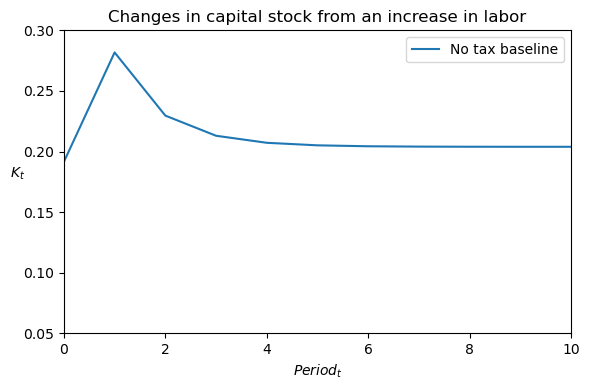

In [7]:
# a. plotting figure
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# b. model without tax
par.tau_w=0.0
par.K_lag_ini = 0.172
model.simulate(shock=True)
baseline = model.sim
ax.plot(baseline.K,label='No tax baseline')

# c. specification of figure
ax.legend(frameon=True)
ax.set_title('Changes in capital stock from an increase in labor')
plt.ylim([0.05, 0.3])
plt.xlim([0,10])
ax.set_xlabel('$Period_t$')
ax.set_ylabel('$K_t$', rotation=0)
fig.tight_layout()


Next we plot the effect of an increase in labor supply with a Fully Funded (FF) and Pay As You Go (PAYG) pension system, where the funding is an income tax.

simulation done in 0.02 secs
simulation done in 0.03 secs
simulation done in 0.03 secs


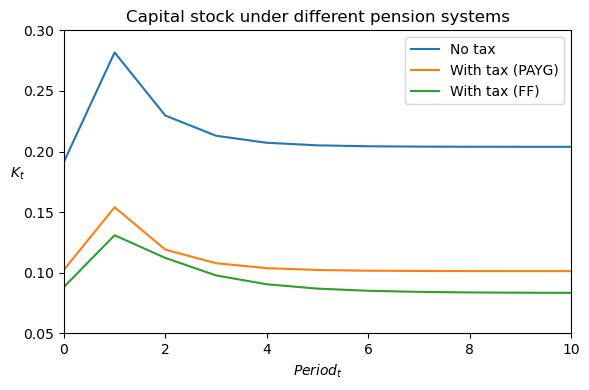

In [8]:
# a. plotting figure
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# b. model without tax
par.tau_w=0.0
par.K_lag_ini = 0.172
model.simulate(shock=True)
baseline = model.sim
ax.plot(baseline.K,label='No tax')

# c. model with payg
par.tau_w = 0.1
par.K_lag_ini = 0.104
model.simulate(shock=True,regime='PAYG')
shockmodelPAYG = model.sim
ax.plot(shockmodelPAYG.K,label='With tax (PAYG)')

# d. model with ff
par.tau_w = 0.1
par.K_lag_ini = 0.093
model.simulate(shock=True,regime='FF')
shockmodelFF = model.sim
ax.plot(shockmodelFF.K,label='With tax (FF)')

# e. specification of figure
ax.legend(frameon=True)
ax.set_title('Capital stock under different pension systems')
plt.ylim([0.05, 0.3])
plt.xlim([0,10])
ax.set_xlabel('$Period_t$')
ax.set_ylabel('$K_t$', rotation=0)
fig.tight_layout()


We can now plot utility with the different pension systems.

simulation done in 0.03 secs
simulation done in 0.03 secs
simulation done in 0.03 secs


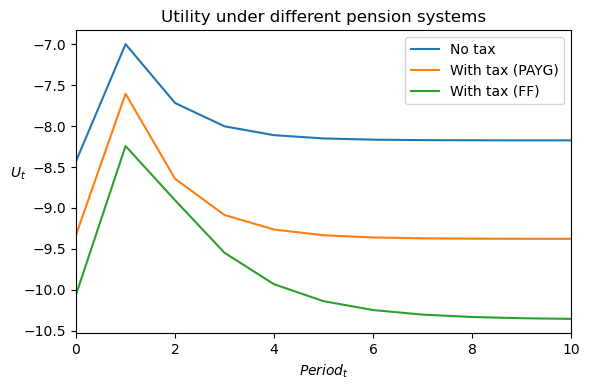

In [9]:
# a. plotting figure
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# b. model without tax
par.tau_w=0.0
par.K_lag_ini = 0.172
model.simulate(shock=True)
baseline = model.sim
ax.plot(baseline.U,label='No tax')

# c. model with payg
par.tau_w = 0.1
par.K_lag_ini = 0.104
model.simulate(shock=True,regime='PAYG')
shockmodelPAYG = model.sim
ax.plot(shockmodelPAYG.U,label='With tax (PAYG)')

# d. model with ff
par.tau_w = 0.1
par.K_lag_ini = 0.093
model.simulate(shock=True,regime='FF')
shockmodelFF = model.sim
ax.plot(shockmodelFF.U,label='With tax (FF)')

# e. specification of figure
ax.legend(frameon=True)
ax.set_title('Utility under different pension systems')
plt.xlim([0,10])
ax.set_xlabel('$Period_t$')
ax.set_ylabel('$U_t$', rotation=0)
fig.tight_layout()


# Conclusion

We find a 1 period increase in labor supply does strictly better in the model without taxation than the other models. Further, PAYG does strictly better than FF. That the no tax model performs better can be explained by a higher savingsrate due to lower taxation whereby workers are more productive due to a higher level of capital. In terms of PAYG vs FF the advantage of the PAYG model stems from the fact that we have growth in employment. As such in the period with growth the young are able to consume more, as the pension payments of the future are larger, because they are taken from a new and larger young generation. We note, that our results aren't fully as they should be. In period 0, where the old and young generation are of equal size and constant, we should have, that our PAYG and FF models essentially should be equal. We have not been able to finde the source of the issue.